# 3D *tobac* Tutorial: Gridded Radar Data

This tutorial will demonstrate how to use *tobac* to detect and track convection with gridded radar data. 

In [1]:
%matplotlib inline

#### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import pyart
import datetime
import matplotlib.gridspec as gridspec
import tobac
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


### Load and Preprocess Data

In [3]:
# load in 
radar_data_files = (
    "s3://noaa-nexrad-level2/2017/05/25/KCYS/KCYS20170525_172649_V06",
    "s3://noaa-nexrad-level2/2017/05/25/KCYS/KCYS20170525_173109_V06",
    "s3://noaa-nexrad-level2/2017/05/25/KCYS/KCYS20170525_173528_V06",
    "s3://noaa-nexrad-level2/2017/05/25/KCYS/KCYS20170525_173934_V06"
)

all_radar_data = dict()
for radar_file_name in radar_data_files:
    radar_time_str = radar_file_name.split('/')[-1][4:-4]
    radar_time = datetime.datetime.strptime(radar_time_str, '%Y%m%d_%H%M%S')
    all_radar_data[radar_time] = pyart.io.read_nexrad_archive(radar_file_name)


*tobac* is designed to work with **gridded** data, so we must first grid the radial radar data. This is a quick and dirty gridding, but it will get the job done for this tutorial. Much better gridding results could be had with tuning of the parameters.

In [4]:
all_radar_gridded = dict()
for radar_time in all_radar_data:
    all_radar_gridded[radar_time] = pyart.map.grid_from_radars(all_radar_data[radar_time], grid_shape=(41, 401, 401),
                                  grid_limits=((0.,20000,), (-200000., 200000.), (-200000, 200000.)))


In [5]:
all_times = list(all_radar_gridded)

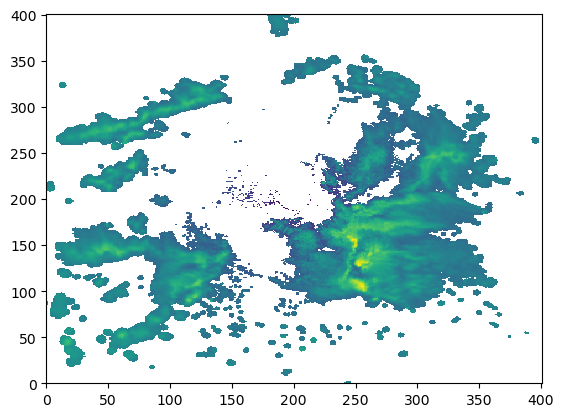

In [6]:
plt.pcolormesh(all_radar_gridded[all_times[3]].to_xarray()['reflectivity'][0,6])

In [7]:
all_xr_grids = list()
for radar_time in all_radar_gridded:
    all_xr_grids.append(all_radar_gridded[radar_time].to_xarray())

In [8]:
all_xr_data = xr.concat(all_xr_grids, 'time')

## *tobac* Feature Detection

In [9]:
feature_detection_params = dict()
feature_detection_params['threshold'] = [30, 40, 50]
feature_detection_params['target'] = 'maximum'
feature_detection_params['position_threshold'] = 'weighted_diff'
feature_detection_params['n_erosion_threshold'] = 2
feature_detection_params['sigma_threshold'] = 1
feature_detection_params['n_min_threshold'] = 4


Note that to track in 3D, we must give information about what our height coordinate is. Iris tends to be picky about the naming conventions, so we need to assign standard names as well.

In [10]:
xr_grid_full = all_xr_data['reflectivity']
xr_grid_full['z'] = xr_grid_full.z.assign_attrs({'standard_name': 'altitude'})
xr_grid_full['lat'] = xr_grid_full.lat.assign_attrs({'standard_name': 'latitude'})
xr_grid_full['lon'] = xr_grid_full.lon.assign_attrs({'standard_name': 'longitude'})

In [11]:
out_fd = tobac.feature_detection_multithreshold(xr_grid_full, 0, **feature_detection_params)

In [12]:
out_fd

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,y,x,ProjectionCoordinateSystem,projection,origin_latitude,origin_longitude,origin_altitude,z
0,0,1,7.461340,101.516197,243.322103,601,30,1,2017-05-25 17:26:49.098000,2017-05-25 17:26:49,40.265098,-104.295467,-98483.803226,43322.102771,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,3730.669856
1,0,2,6.205166,128.319109,246.297396,70,30,2,2017-05-25 17:26:49.098000,2017-05-25 17:26:49,40.505974,-104.258436,-71680.891079,46297.396490,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,3102.583175
2,0,3,3.958096,151.380294,242.136976,422,30,3,2017-05-25 17:26:49.098000,2017-05-25 17:26:49,40.713588,-104.306089,-48619.706170,42136.976135,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,1979.048186
3,0,4,3.382241,166.749490,251.163372,20,30,4,2017-05-25 17:26:49.098000,2017-05-25 17:26:49,40.851287,-104.197729,-33250.509891,51163.371809,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,1691.120744
4,1,1,8.143188,102.781420,247.378227,710,30,5,2017-05-25 17:31:09.447000,2017-05-25 17:31:09,40.276254,-104.247571,-97218.580067,47378.227328,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,4071.593988
5,1,2,5.603158,129.459213,248.536406,155,30,6,2017-05-25 17:31:09.447000,2017-05-25 17:31:09,40.516098,-104.231867,-70540.787314,48536.406184,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,2801.579234
6,1,3,4.197920,154.231072,246.015737,775,30,7,2017-05-25 17:31:09.447000,2017-05-25 17:31:09,40.739016,-104.259859,-45768.927841,46015.736635,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,2098.960078
7,1,5,3.023899,178.998573,245.652524,8,30,8,2017-05-25 17:31:09.447000,2017-05-25 17:31:09,40.961769,-104.262341,-21001.427135,45652.524363,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,1511.949287
8,2,1,8.341449,104.282326,251.299525,726,30,9,2017-05-25 17:35:28.718000,2017-05-25 17:35:28,40.289517,-104.201229,-95717.673843,51299.525410,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,4170.724557
9,2,2,7.187612,130.248964,251.829538,263,30,10,2017-05-25 17:35:28.718000,2017-05-25 17:35:28,40.522999,-104.192846,-69751.036244,51829.537594,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,3593.806245


In [13]:
out_tracking = tobac.linking_trackpy(out_fd, None, 300, dxy = 2000, v_max=30)

Frame 3: 5 trajectories present.


In [14]:
out_tracking

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,...,y,x,ProjectionCoordinateSystem,projection,origin_latitude,origin_longitude,origin_altitude,z,cell,time_cell
0,0,1,7.461340,101.516197,243.322103,601,30,1,2017-05-25 17:26:49.098000,2017-05-25 17:26:49,...,-98483.803226,43322.102771,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,3730.669856,1,0 days 00:00:00
1,0,2,6.205166,128.319109,246.297396,70,30,2,2017-05-25 17:26:49.098000,2017-05-25 17:26:49,...,-71680.891079,46297.396490,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,3102.583175,2,0 days 00:00:00
2,0,3,3.958096,151.380294,242.136976,422,30,3,2017-05-25 17:26:49.098000,2017-05-25 17:26:49,...,-48619.706170,42136.976135,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,1979.048186,3,0 days 00:00:00
3,0,4,3.382241,166.749490,251.163372,20,30,4,2017-05-25 17:26:49.098000,2017-05-25 17:26:49,...,-33250.509891,51163.371809,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,1691.120744,4,0 days 00:00:00
4,1,1,8.143188,102.781420,247.378227,710,30,5,2017-05-25 17:31:09.447000,2017-05-25 17:31:09,...,-97218.580067,47378.227328,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,4071.593988,1,0 days 00:04:20.349000
5,1,2,5.603158,129.459213,248.536406,155,30,6,2017-05-25 17:31:09.447000,2017-05-25 17:31:09,...,-70540.787314,48536.406184,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,2801.579234,2,0 days 00:04:20.349000
6,1,3,4.197920,154.231072,246.015737,775,30,7,2017-05-25 17:31:09.447000,2017-05-25 17:31:09,...,-45768.927841,46015.736635,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,2098.960078,5,0 days 00:00:00
7,1,5,3.023899,178.998573,245.652524,8,30,8,2017-05-25 17:31:09.447000,2017-05-25 17:31:09,...,-21001.427135,45652.524363,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,1511.949287,6,0 days 00:00:00
12,2,8,1.059521,152.559558,246.000000,13,40,13,2017-05-25 17:35:28.718000,2017-05-25 17:35:28,...,-47440.442349,46000.000000,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,529.760465,5,0 days 00:04:19.271000
11,2,6,2.705102,181.131671,248.651761,8,30,12,2017-05-25 17:35:28.718000,2017-05-25 17:35:28,...,-18868.328864,48651.761498,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,1352.551043,6,0 days 00:04:19.271000


In [15]:
cell_2_out = out_tracking[out_tracking['cell']==2]

In [16]:
cell_2_out

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,...,y,x,ProjectionCoordinateSystem,projection,origin_latitude,origin_longitude,origin_altitude,z,cell,time_cell
1,0,2,6.205166,128.319109,246.297396,70,30,2,2017-05-25 17:26:49.098000,2017-05-25 17:26:49,...,-71680.891079,46297.396490,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,3102.583175,2,0 days 00:00:00
5,1,2,5.603158,129.459213,248.536406,155,30,6,2017-05-25 17:31:09.447000,2017-05-25 17:31:09,...,-70540.787314,48536.406184,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,2801.579234,2,0 days 00:04:20.349000
9,2,2,7.187612,130.248964,251.829538,263,30,10,2017-05-25 17:35:28.718000,2017-05-25 17:35:28,...,-69751.036244,51829.537594,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,3593.806245,2,0 days 00:08:39.620000
14,3,2,7.324813,131.144139,254.726020,502,30,15,2017-05-25 17:39:34.275000,2017-05-25 17:39:34,...,-68855.861373,54726.019972,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,41.15192,-104.80603,1887.0,3662.406505,2,0 days 00:12:45.177000


In [17]:
def round_seconds(obj: datetime.datetime) -> datetime.datetime:
    if obj.microsecond >= 500_000:
        obj += datetime.timedelta(seconds=1)
    return obj.replace(microsecond=0)


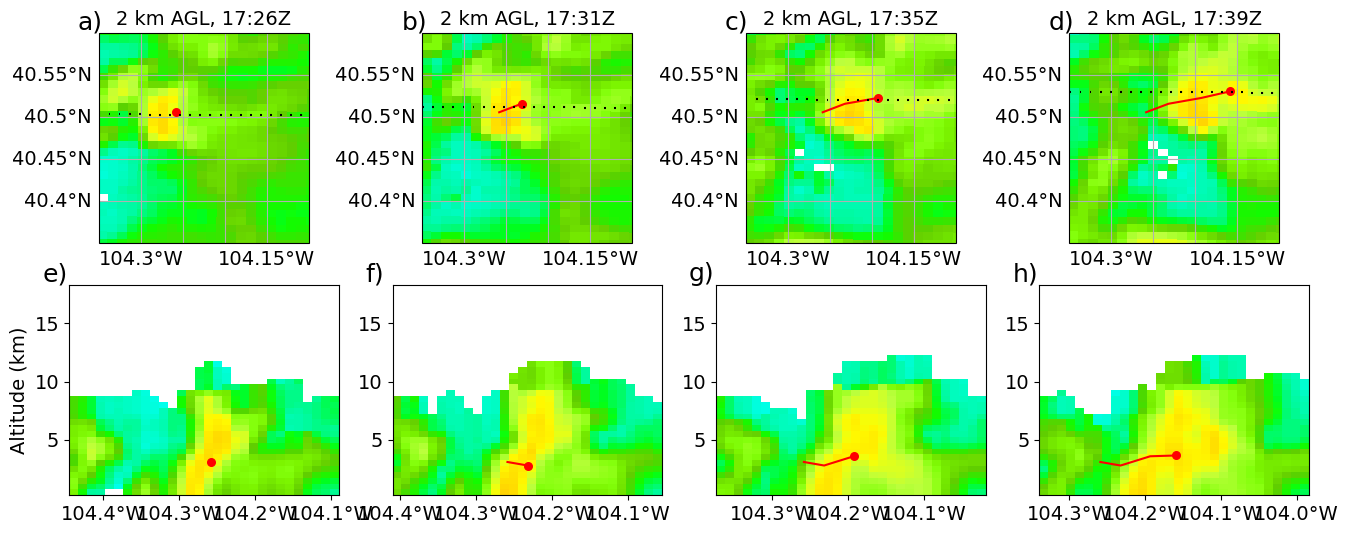

In [18]:
fig = plt.figure(figsize=[16, 6])
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
all_ax = list()
x_range = 15
for i, radar_time in enumerate(all_xr_data.time):
    radar_time_str = str(radar_time.values).split('.')[0]
    exact_dt_radar = pd.to_datetime(radar_time.values.astype('datetime64[ns]'))
    pydt_radar = exact_dt_radar.to_pydatetime()
    pydt_radar = round_seconds(pydt_radar)

    ax = fig.add_subplot(spec[0,i], projection=ccrs.PlateCarree())
    all_ax.append(ax)
    curr_xr_data = all_xr_data.sel(time=radar_time)
    ax.set_extent([-104.35, -104.1, 40.35, 40.6], crs=ccrs.PlateCarree())

    cm = ax.pcolormesh(all_xr_data['lon'], all_xr_data['lat'], curr_xr_data['reflectivity'][4], vmin=-30, vmax=95, 
                    transform=ccrs.PlateCarree(), cmap = 'gist_ncar')

    states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize':14}
    gl.ylabel_style = {'fontsize': 14}
    
    #cb = plt.colorbar(cm)
    #cb.set_label("Reflectivity (dBZ)", size=14)
    #cb.ax.tick_params(labelsize=14)
    plt.title("2 km AGL, "+pydt_radar.strftime("%H:%MZ"), size=14)
    #pydt_radar = pydt_radar.replace(microsecond=round(pydt_radar.microsecond, -3))
    curr_time_cell = cell_2_out[cell_2_out['time']==exact_dt_radar]
    past_time_cell = cell_2_out[cell_2_out['time']<=exact_dt_radar]
    min_x_pt = round(curr_time_cell['hdim_2'].values[0])-x_range
    max_x_pt = round(curr_time_cell['hdim_2'].values[0])+x_range
    curr_y_pt = round(curr_time_cell['hdim_1'].values[0])

    ax.scatter(curr_time_cell['lon'], curr_time_cell['lat'], 30, transform=ccrs.PlateCarree(), color='r')
    ax.plot(past_time_cell['lon'].values, past_time_cell['lat'].values, color='r', transform=ccrs.PlateCarree())
    ax.plot([all_xr_data['lon'][min_x_pt], all_xr_data['lon'][max_x_pt]], [all_xr_data['lat'][curr_y_pt], all_xr_data['lat'][curr_y_pt]], color='k', ls=':',
                transform=ccrs.PlateCarree())
    #plt.savefig("./radar_example_2/base_ref_202105261556_withfeatures.png", facecolor='w', bbox_inches='tight')
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
for i, radar_time in enumerate(all_xr_data.time):
    ax = fig.add_subplot(spec[1,i])
    all_ax.append(ax)
    exact_dt_radar = pd.to_datetime(radar_time.values.astype('datetime64[ns]'))

    pydt_radar = exact_dt_radar.to_pydatetime()
    pydt_radar = round_seconds(pydt_radar)
    curr_xr_data = all_xr_data.sel(time=radar_time)
    curr_time_cell = cell_2_out[cell_2_out['time']==exact_dt_radar]
    curr_y_pt = round(curr_time_cell['hdim_1'].values[0])
    min_x_pt = round(curr_time_cell['hdim_2'].values[0])-x_range
    max_x_pt = round(curr_time_cell['hdim_2'].values[0])+x_range
    min_z_pt = 1
    max_z_pt = 37
    lm, zm = np.meshgrid(all_xr_data['lon'][curr_y_pt, min_x_pt:max_x_pt], (all_xr_data['z']/1000)[min_z_pt:max_z_pt])
    cm = ax.pcolormesh(lm, zm, 
        curr_xr_data['reflectivity'][min_z_pt:max_z_pt, curr_y_pt, min_x_pt:max_x_pt], cmap = 'gist_ncar',  vmin=-30, vmax=95,)
    past_time_cell = cell_2_out[cell_2_out['time']<=exact_dt_radar]

    ax.scatter(curr_time_cell['lon'], curr_time_cell['z']/1000, 30, color='r')
    ax.plot(past_time_cell['lon'].values, past_time_cell['z'].values/1000, color='r')
    ax.tick_params(labelsize=14)
    lon_formatter = LongitudeFormatter(number_format='.1f',
                                       dateline_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    if i == 0:
        ax.set_ylabel("Altitude (km)", size=14)

    

label_prefix = ''
label_suffix = ')'
for ax, label in zip(all_ax, 'abcdefghijklmno'):
    ax.text(-0.1,1.02, label_prefix+label+label_suffix, transform=ax.transAxes, size=18)

plt.savefig("3D_track_example.png", dpi=300)